In [44]:
# Βιβλιοθήκες
import pandas as pd
import numpy as np
import gekko as gk
import seaborn as sns
import xarray as xr
from matplotlib import pyplot as plt
import typing
import pymc
import itertools
import math
import functools
from pca import pca
from IPython.display import display, HTML
import prince
import networkx
import sklearn
import tensorflow as tf
from tensorflow import keras
import multiprocessing
from imblearn.over_sampling import ADASYN, SMOTE
import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from itertools import product

In [3]:
# Γενικές επιλογές εμφάνισης
pd.set_option('display.max_rows',10)
pd.set_option('display.max_columns',30)
sns.set(rc={'figure.figsize':(14,9)})
sns.set(font_scale = 0.75)

In [4]:
# Utilities
from sklearn.preprocessing import StandardScaler

std_scale = lambda df: pd.DataFrame(data = StandardScaler().fit_transform(df), columns = df.columns, index=df.index)

def render_df(df:pd.DataFrame):
    from IPython.display import display, HTML
    display(HTML(df.to_html()))
    return

def full_display(r=None, c=None):
    pd.set_option('display.max_rows', r)
    pd.set_option('display.max_columns',c)
    return

def reset_display():
    pd.set_option('display.max_rows',10)
    pd.set_option('display.max_columns',30)

def full_display_once(df:pd.DataFrame, r=None, c=None):
    full_display(r=r, c=c)
    render_df(df)
    reset_display()

def rowwise_value_counts(df:pd.DataFrame):
    vcounts_df = pd.DataFrame(data = df.apply(lambda x: x.value_counts()).T.stack()).astype(int).T
    vcounts_df.index = ['']
    return vcounts_df

invert_dict = lambda e: {v:k for k, v in e.items()}

def categorical_scatter(X:pd.DataFrame, Y:typing.Optional[pd.DataFrame],cols:int=3,max_rows:int = 3,
                             figsize:tuple[int, int] = (30, 15), xaxis_label_size: int=12,
                             yaxis_label_size:int=12, categorical:typing.Optional[str]='hue')->typing.Optional[plt.figure]:
    '''
        Generate pair-wise scatter plots for a given DataFrame, with optional support for large Datasets
        and categorical variables. Yields a figure with `max_rows x cols` scatterplots per call. When
        `categorical=None` only generates pair-wise scatterplots for the columns of X, else generates all
        combinations of X-column pair and Y columns. When `categorical='hue'` values of the categorical Y
        variable will be depicted color-coded and when `categorical=size` different factors of the Y variable
        will have different sizes instead.
        
        Args:
        -----
        
            - X:pandas.DataFrame := The data to depict. When Y is also specified, X is assumed to be the DataFrame
            of indicator variables
            
            - Y:Optional[pandas.DataFrame] := Optional Dataframe of categorical variables to depict. Ignored if 
            `category` is `None`.
            
            - idx_lvl:int=1 := For multilevel indexed dataframes the lowest level to squash the index on. Must be non-negative
            
            - cols:int=3 := Number of columns for the resulting facet grid plot. Must be non-negative. Defaults to 3
            
            - max_rows:int=3 := Maximum number of rows per batch the generator yields. Defaults to 3 and must be non-negative
            
            - figsize:tuple[int, int] := A `height x width` tuple for the generated plots. Defaults to `(30, 15)`
            
            - xaxis_label_size:int=12 := The size of the x-axis titles for each subplot. Must be non-negative and defaults to 12
            
            - yaxis_label_size:int=12 := The size of the y-axis titles for each subplot. Must be non-negative and defaults to 12
            
            - categorical:Optional[str] := Set the display of the categorical variable. (1) `None` ignores `Y` and only displays X
            pair-wise scatterplots, (2) 'hue' displays the categorical variable of `Y` as color and (3) 'size' displays
            the categorical variable with differently sized points
            
        Returns:
        --------
        
            - fig:matplotlib.pyplot.figure := The figure object, a FacetPlot of scatterplots
            
       
       Raises:
        ------
        
            - WIP
            
            - ValueError 
    '''
    XY = pd.concat([Y, X], axis=1)
    idx_lvl= XY.columns.nlevels-1
    skip_multiindex = lambda df,i , idx_level=idx_lvl: df.columns[i][idx_level] if idx_level else df.columns[i]
    if idx_lvl:
        XY.columns = XY.columns.get_level_values(idx_lvl)
    x_combs = math.comb(X.shape[1], 2)
    MAX_ROWS = max_rows
    
    if categorical is not None:
        plots = x_combs*Y.shape[1]
    else:
        plots = x_combs
    ncols = cols
    size_scaling_factor = None
    total_rows = math.ceil(plots/ncols)
    total_figures = math.ceil(total_rows/MAX_ROWS)
    X_pairs = itertools.combinations(range(X.shape[1]), 2)
    subplots = itertools.product(X_pairs,range(Y.shape[1]) ) if categorical is not None else X_pairs
    exhaustion_sentinel = False
    while True:
        if exhaustion_sentinel: break
        fig, axs = plt.subplots(nrows=MAX_ROWS, ncols=ncols, figsize=figsize)
        ax_indices = itertools.product(range(MAX_ROWS), range(ncols), repeat=1)
        plotslice = itertools.islice(subplots, MAX_ROWS*ncols)
        fig_generator = itertools.zip_longest( ax_indices, plotslice, fillvalue = ((None, None), None) )
        for (axi, axj), e in fig_generator:
            e = tuple(flatten(e))
            if e[0] is not None:
                if categorical == 'size':
                    sns.scatterplot(x=skip_multiindex(chem_indicators, e[0]), y=skip_multiindex(chem_indicators, e[1]), data=XY,
                       size=skip_multiindex(origin_targets, e[2]), ax=axs[axi, axj], legend=True)
                elif categorical == 'hue':
                    sns.scatterplot(x=skip_multiindex(chem_indicators, e[0]), y=skip_multiindex(chem_indicators, e[1]), data=XY,
                       hue=skip_multiindex(origin_targets, e[2]), ax=axs[axi, axj], legend=True)
                elif categorical is None:
                    sns.scatterplot(x=skip_multiindex(chem_indicators, e[0]), y=skip_multiindex(chem_indicators, e[1]), data=XY,
                       ax=axs[axi, axj], legend=True)
                axs[axi, axj].set_xlabel(skip_multiindex(chem_indicators, e[0]))
                axs[axi, axj].set_ylabel(skip_multiindex(chem_indicators, e[1]))
                axs[axi, axj].xaxis.label.set_size(xaxis_label_size)
                axs[axi, axj].yaxis.label.set_size(yaxis_label_size)
                
            else:
                axs[axi, axj].axis('off')
                exhaustion_sentinel = True
        yield fig 
    return None



def flatten(xs):
    from collections.abc import Iterable
    for x in xs:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            yield from flatten(x)
        else:
            yield x

def tidy_multiindex(df:pd.DataFrame, sep:str="."):
    '''
        Compress a hierarchically indexed dataframe to standardized tidy
        format. A unique sepperator `sep` is used to allow reversal. All
        levels of the index are appended together with a delimeter to allow
        reversals.
        
        Args:
        ----
        
            - df:pandas.DataFrame := A `pandas.DataFrame` hierarchically indexed
            
            - sep:str='_._' := A delimenter delineating the different levels
            of the index. Ensure it is not present in any column name to avoid
            a malformed index
            
        Returns:
        --------
        
            - ndf:pandas.DataFrame := The DataFrame with a single-level index
    '''
    tidy_cols = (functools.reduce(lambda e1,e2: str(e1)+sep+str(e2), col ) for col in df.columns)
    ndf = df.copy(deep=True)
    ndf.columns = tidy_cols
    return ndf

def reverse_tidy_multiindex(df:pd.DataFrame, sep="."):
    '''
        Reverses the tidying to a hierachical format. Different
        levels of the index are identified based on "sep"
        
        Args:
        -----
        
            - df:pandas.DataFrame := The dataframe to process
            
            - sep:str='_._' := The string delimeter, sepperating
            values for different levels of the index
            
        Returns:
        -------
        
            - ndf:pandas.DataFrame := The dataframe with hierarchical index
    '''
    h_cols = (tuple(col.split(sep)) for col in df.columns)
    ndf = df.copy(deep=True)
    ndf.columns = pd.MultiIndex.from_tuples(h_cols)
    return ndf

def undummify(df:pd.DataFrame,cols:list[str, tuple[str]],ncol_name:typing.Union[str,tuple[str]],
              sep:typing.Optional[str]=None,
              rmap:typing.Optional[dict[int, typing.Union[str, tuple[str]]]]=None
             )->pd.DataFrame:
    '''
        Reverses hot-encoded variables in the DataFrame. A series of hot-encoded
        variable levels $(i_1, i2, \dots, i_k)$ is mapped to a single new column
        $(k)$, whose name is specified by `ncol_name`, in the new dataframe. Pre
        vious level columns are dropped.
        
        Args:
        ----
        
            - df:pandas.DataFrame := The DataFrame to operate upon
            
            - cols:list[str, tuple[str]] := A list of columns, representing the
            levels of a categorical variable
            
            - sep:Optional[str] := sepperator for variable level. Currently ignored
            
            - ncol_name:Union[str, tuple[str]] := Name of the new categorical column
            
            - remap:Optional[dict[int, Union[str, tuple[str]]]] := A dictionary mapping
            of categorical levels to values. Keys are the assumed to be levels, values
            are assumed to be values (i.e. strings). When provided, the previous levels
            will be replaced by the specified mappings in the new DataFrame
            
        Returns:
        -------
        
            - ndf:pandas.DataFrame := The processed dataframe
     '''
    _df = coredf.loc[:, cols]
    for i, col in enumerate(cols, 1):
        _df.loc[:, col] = i*_df.loc[:, col]
    ndf = df.copy(deep=True)
    ndf.drop(cols, axis=1, inplace=True)
    ndf[ncol_name] = _df.max(axis=1)
    c1 = df.columns.tolist()
    i = c1.index(cols[0])
    swp = ndf.columns.tolist()[:i-1]+[ndf.columns.tolist()[-1]]+ndf.columns.tolist()[i:-1]
    ndf = ndf.loc[:, swp]
    if rmap is not None:
        ndf = ndf.replace(rmap)
    return ndf
list_difference = lambda l1, l2: [e for e  in l1 if e not in set(l2)]

def corrspace_graph(df:pd.DataFrame):
    '''
        Generate a correlation graph representation of `df` datasets.
        Every node in the resulting graph is a variable and every 
        vertex between two nodes represents the correlation between
        the two variables, the correlation being the verted weight
        
        Args:
        ----
        
            - df:pandas.DataFrame := A dataset to depict
            
        Returns:
            - WIP
    '''
    
    return 

In [5]:
def tf_model(Xtrain, Xtest, Ytrain, Ytest, loss:str='categorical_crossentropy',
             optimizer:str='adadelta',
             layers:typing.Optional[list[tuple[int, str]]]=None,
             metrics=['accuracy'], summary:bool=True, epochs:int=10,
             factivation:str='sigmoid',batch:int=64, callbacks:list=[],
            verbosity:int=1):
    M = Xtrain.shape[1]
    input_layer = tf.keras.Input(shape=(M,))
    x = input_layer
    for neurons, activation in layers:
        x = tf.keras.layers.Dense(math.ceil(neurons), activation=activation)(x)

    x = tf.keras.layers.Dense(math.ceil(Ytrain.shape[1]), activation=factivation)(x)
    model = tf.keras.models.Model(inputs=input_layer, outputs=x)
    model.compile(optimizer=optimizer, loss=loss, 
                metrics=metrics)
    if summary:
        model.summary()
    model.fit(Xtrain, Ytrain, epochs=epochs, validation_data = (Xtest, Ytest),
              batch_size=batch, callbacks=callbacks, verbose=verbosity)
    return model

In [6]:
def tf_autoencoder(Xtrain, Xtest, Ytrain, Ytest, loss:str='categorical_crossentropy',
             optimizer:str='adadelta',
             layers:typing.Optional[list[tuple[int, str]]]=None,
             metrics=['accuracy'], summary:bool=True, epochs:int=10,
             activation:str='sigmoid',batch:int=64 ):
    M = X.shape[1]
    input_layer = tf.keras.Input(shape=(M,))
    x = input_layer
    rev_layers = copy(layers)
    rev_layers.reverse()
    for neurons, activation in layers:
        x = tf.keras.layers.Dense(math.ceil(neurons), activation=activation)(x)
    encoder = x
    for neurons, activations in rev_layers:
        x = tf.keras.layers.Dense(math.ceil(neurons), activation=activation)(x)
    x = tf.keras.layers.Dense(math.ceil(Ytrain.shape[1]), activation='sigmoid')(x)
    decoder = x
    model = tf.keras.models.Model(inputs=input_layer, outputs=x)
    model.compile(optimizer=optimizer, loss=loss, 
                metrics=metrics)
    if summary:
        model.summary()
    model.fit(Xtrain, Ytrain, epochs=epochs, validation_data = (Xtest, Ytest),
              batch_size=batch, verbose=1)
    return model

In [7]:
df_raw = pd.read_excel("Συγκεντρωτικό Ελαιόλαδου.xlsx", decimal=',')

## Γενικά

Τα δεδομένα μας απαρτίζονται από χημικές και φυσικοχημεικές παραμέτρους, παραμέτρους χαρακτηρισμού προέλευσης (ποικηλία, γεωγραφική προέλευση) και δεδομένα εδαφικών χαρακτηριστικών. Τα εδαφικά δεδομένα είναι λιγοστά ώστε πρακτικά δεν θα χρησιμοποιηθούν καθόλου. Η ποικηλία εμπεριέχει και μικτούς χαρακτηρισμούς (πχ 60% αδραμυτιανή, 40% κολοβή). Οι παράμετροι χαρακτηρισμού προέλευσης (και μεθόδου παραγωγής) είναι κατηγορικές μεταβλητές και αντιπροσωπεύονται με "ενα σε Κ κωδικοποίηση" *(one-to-k encoding)*.
Οι χημικές παράμετροι διακρίνονται σε
1. αντιοξειδωτικά
2. χρωστικές
3. dags
4. στερόλες
5. λιπαρά οξέα
6. κήρους
7. αιθυλεστέρες

Οι φυσικοχημικές παράμετροι είναι:

1. οξύτητα
2. περοξείδια
3. συντελεστής ($Κ232$)
4. συντελεστής ($Κ270$)
5. συντελεστής ($ΔK$)

Οι οργανοληπτικές παράμετροι θα μοντελοποιηθούν χωριστά λόγο ιδιαιτεροτήτων τους και είναι:
1. Διάμεση τιμή φρουτώδους ($M_f$)
2. Διάμεση τιμή πικρού ($M_b$)
3. Διάμεση τιμή πικάντικου ($M_p$)
4. Διάμεση τιμή ελαττώματος ($M_d$) 
5. Παρατηρήσεις

Οι παράμετροι προέλευσεις μπορούν να διακριθούν περαιτέρο σε παραμέτρους "καλλιέργειας" (*cultivar*) και παραμέτρους παραγωγής (ή ελαιοποίησης *oilification*). Οι παράμετροι καλλιέργειας είναι:

1. Ποικηλία:
     * Κολοβή
     * Αδραμυτιανή
     * Λέσσινο
     * Λαδοελιά
     * Αγρινιότικη
     * Πατρινή
     * Κρητική
     * Κορωνέικη
     * Αρμπεκίνα
     * Χονδροελιά
     * Θρούμπα
     * Δαφνοελιά
     * Μανάκι
     * Άμφυσας
     * Καλάμων
     * Χιώτικη
2. Γεωγραφική Προέλευση:
    * Λέσβος
    * Σάμος
    * Χίος 
    * Ικαρία 
    * Φούρνοι
3. Άρδευση (boolean)
4. Λίπανση* (Κοπριά, Λίπανση, Ναι, Όχι) !!
5. Ωρίμανση (Π, ΠΑ, ΠΙ, Μ) (k-enc)
6. Οργανική Καλλιέργεια (boolean)
7. Υψόμετρο (Ορεινό, Ημιορεινό, Πεδινό) (k-enc)

Οι παράμετροι ελαιοποίησης είναι:

1. Ημέρες έως ελαιοποίηση
2. Μέθοδος συλλογής
    * Τεμπ
    * Μηχανικά (Μηχ. ελαι.)
    * Ελαίοδ
    * Δίχτυ
    * Σακ. Δικτ
    * Χτένι
3. Τύπος Φυγοκέντρισης (boolean)
4. Προσθήκη Νερού (boolean)
5. Χρόνος Μάλαξης (int>0)
6. Θερμοκρασία Μάλαξης (int>0)
7. Θερμοκρασία Διαχωριστήρα (int>0)

  Για ορισμένες ποικηλίες έχουμε ελάχιστες παρατηρήσεις (Πατρινή, Κρητική, Άμφυσας, Καλάμων) και δύσκολα μπορούμε να βγάλουμε συμπεράσματα. Η Λέσβος έχει διαχωριστεί σε υπό περιοχές - ζώνες. Θα μπορούσε να κατασκευαστεί μοντέλο γι αυτές ξεχωριστά (αφού οι υπόλοιπες περιοχές δεν διακρίνονται σε ζώνες). Για την λίπανση, έχουμε καταγραφές μορφής ΝΑΙ/ΟΧΙ στη μία παρτίδα και αναλυτικότερη (ΟΧΙ, ΚΟΠΡΙΑ, ΛΙΠΑΣΜΑ) στην άλλη. Συνεπώς αρχικά θα αναγάγουμε όλες τις καταγραφές σε  ΝΑΙ/ΟΧΙ χρησιμποιώντας και τα δύο σύνολα δειγμάτων και αργότερα μπορούμε να κατασκευάσουμε μοντέλο ιδιαίτερα για τη διάκριση Κοπριάς/Λιπάσματος. 
  Υπάρχουν αρκετές ελλειπής καταγραφές στις άνω κατηγορίες, συνεπώς αρχικά θα τις απορρίψουμε εντελώς και κατόπιν θα επιχειρήσουμε *imputation*. Οι περισσότερες κατηγορικές μεταβλητές-στόχοι προέλευσης μπορούν να αντιπροσωπευθούν με κ-κωδικοποίηση. Ιδιαίτερη περίπτωση αποτελεί η ποικηλία. Επειδή αυτή είναι σε πολλά δείγματα μεικτή, με γνωστές αναλογές, θα επιχειρήσουμε διαδικασία αντίστοιχη της κ-κωδικοποίησης, επιλύωντας πρόβλημα βελτιστοποίησης **υπό συνθήκες**. Θα επιχειρήσουμε να κατασκευάσουμε μοντέλο παλινδρόμησης ποσοστού κάθε ποικηλίας υπό συνθήκη αθροίσματος στη μονάδα. Για όλες τις υπόλοιπες παραμέτρους προέλευσης μπορούμε να χρησιμοποιήσουμε οποιοδήποτε μοντέλο classification, και επειδή η προέλευση έχει ιδιαιτερώτητες θα κατασκευάσουμε το αντίστοιχο μοντέλο χωριστά, τουλάχιστον στα αρχικά στάδια. Για τις μεθόδους συλλογής χρειαζομαστε διευκρινήσεις.

 Πιθανά μοντέλα ενδιαφέροντως
 * Γεωγραφικές Παράμετροι από χημικές
 * Οργανοληπτικές + Φυσικοχημικές από χημικές
 * Οργανοληπτικές + Φυσικοχημικές από προέλευση (path analysis?)
 * Σχέση παραμέτρων παραγωγής και προέλευσης σε ποιοτικές
 * SEM σε παραμέτρους ποιότητας

In [8]:
multindex = [
            np.array(['id']*3 + ['origin']*54 + ['chemical']*44 +['phys']*10+['chemical']*37 + ['soil']*20),
            np.array(['id']*3 + ['location']*2 + ['cultivar']*23+['cultivation']*9 +['production']*20+['antiox']*27+['pigm']*8+['dags']*9+['phys']*5+['org']*5+['f_acids']*15+['sterols']*20+['waxes', 'ethylesters']+['soil']*20),
            np.array(df_raw.columns.to_list())]
pdf = pd.DataFrame(data = df_raw.values, columns = multindex)
pdf.replace(
    {()}
)

id                                    origin                          \
       id                                  location           cultivar        
      gid                  tofid     dname       zn     loc       rvar uvar   
0    1043  1043KAMB_GA4_01_25728  1043ΚΑΜΒ      6.0  LESVOS    K50AD50    0   
1    1044  1044ELKP_GE8_01_25764  1044ΕΛΚΠ      7.0  LESVOS    K70AD30    0   
2    1066  1066ELKP_GB8_01_25861  1066ΕΛΚΠ      1.0  LESVOS   K60ADR40    0   
3    1074  1074KAGK_GC1_01_25862  1074ΚΑΓΚ      1.0  LESVOS   K50ADR50    0   
4    1087      1087_RE7_01_26470  1087ΕΛΣΓ      1.0  LESVOS     KOLOVI    0   
..    ...                    ...       ...      ...     ...        ...  ...   
530  9157                    NaN  X31 GILA      1.0   CHIOS  ΚΟΡΩΝΕΙΚΗ    0   
531  9158                    NaN  X40 KOKG      1.0   CHIOS   ΘΡΟΥΜΠΑ     0   
532  9159                    NaN  X41 KOKS      1.0   CHIOS   ΘΡΟΥΜΠΑ     0   
533  9160                    NaN  X42 KOKS      1.0   CHIOS  ΚΟΡΩΝΕΙΚΗ    0   
534  9161                    NaN   X43GIMM      1.0   CHIOS  ΚΟΡΩΝΕΙΚΗ    0   

                                         ... soil                           \
                                         ... soil                            
    ucul  kol  kor lad adr  thr hon kal  ... cond caco orga nano  nnh phos   
0      0   50    0   0  50    0   0   0  ...  NaN  NaN  NaN  NaN  NaN  NaN   
1      0   70    0   0  30    0   0   0  ...  NaN  NaN  NaN  NaN  NaN  NaN   
2      0   60    0   0  40    0   0   0  ...  NaN  NaN  NaN  NaN  NaN  NaN   
3      0   50    0   0  50    0   0   0  ...  NaN  NaN  NaN  NaN  NaN  NaN   
4      0  100    0   0   0    0   0   0  ...  NaN  NaN  NaN  NaN  NaN  NaN   
..   ...  ...  ...  ..  ..  ...  ..  ..  ...  ...  ...  ...  ...  ...  ...   
530    0    0  100   0   0    0   0   0  ...  NaN  NaN  NaN  NaN  NaN  NaN   
531    0    0    0   0   0  100   0   0  ...  NaN  NaN  NaN  NaN  NaN  NaN   
532    0    0    0   0   0  100   0   0  ...  NaN  NaN  NaN  NaN  NaN  NaN   
533    0    0  100   0   0    0   0   0  ...  NaN  NaN  NaN  NaN  NaN  NaN   
534    0    0  100   0   0    0   0   0  ...  NaN  NaN  NaN  NaN  NaN  NaN   

                                                   
                                                   
     bor kal.1  mag   ca zn.1   fe   cu   mn salt  
0    NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1    NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2    NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3    NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4    NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
..   ...   ...  ...  ...  ...  ...  ...  ...  ...  
530  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
531  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
532  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
533  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
534  NaN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[535 rows x 168 columns]

In [9]:
# Throw away problematic columns, too many missing values. Sum does not contain unique information
coredf = pdf.drop(columns=['phph','pph','dtoc','syrig','obs', 'eryth', 'ouv', 'bcarot', 'bctoc', 'sum', 'kadr'],level=2)
coredf = coredf.drop(columns=['soil'],level=0)
coredf = coredf.drop(columns=['dags'],level=1)
coredf = coredf.drop(columns=['rvar','org', 'alt', 'fert', 'mat', 'colmeth', 'watadd'], level=2)
# Replace <0.01 entries with zeros
coredf.replace('<0,01',0.00, inplace=True)
coredf.loc[:,[('chemical', 'f_acids', '1trans'),('chemical', 'f_acids', '23trans')]] = coredf.loc[:,[('chemical', 'f_acids', '1trans'),('chemical', 'f_acids', '23trans')]].astype('float64')
coredf.loc[:, 'origin']

/tmp/ipykernel_5862/2428789659.py:8: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  coredf.loc[:,[('chemical', 'f_acids', '1trans'),('chemical', 'f_acids', '23trans')]] = coredf.loc[:,[('chemical', 'f_acids', '1trans'),('chemical', 'f_acids', '23trans')]].astype('float64')


location         cultivar                                                  \
          zn     loc     uvar ucul  kol  kor lad adr  thr hon kal man chi kou   
0        6.0  LESVOS        0    0   50    0   0  50    0   0   0   0   0   0   
1        7.0  LESVOS        0    0   70    0   0  30    0   0   0   0   0   0   
2        1.0  LESVOS        0    0   60    0   0  40    0   0   0   0   0   0   
3        1.0  LESVOS        0    0   50    0   0  50    0   0   0   0   0   0   
4        1.0  LESVOS        0    0  100    0   0   0    0   0   0   0   0   0   
..       ...     ...      ...  ...  ...  ...  ..  ..  ...  ..  ..  ..  ..  ..   
530      1.0   CHIOS        0    0    0  100   0   0    0   0   0   0   0   0   
531      1.0   CHIOS        0    0    0    0   0   0  100   0   0   0   0   0   
532      1.0   CHIOS        0    0    0    0   0   0  100   0   0   0   0   0   
533      1.0   CHIOS        0    0    0  100   0   0    0   0   0   0   0   0   
534      1.0   CHIOS        0    0    0  100   0   0    0   0   0   0   0   0   

         ... production                                             \
    cre  ...     mat_pi mat_p mat_m  doil colmeth_eld colmeth_eldi   
0     0  ...        1.0   0.0   1.0  10.0         0.0          0.0   
1     0  ...        1.0   0.0   1.0   1.0         0.0          0.0   
2     0  ...        0.0   0.0   0.0   0.0         0.0          0.0   
3     0  ...        1.0   0.0   1.0   5.0         0.0          0.0   
4     0  ...        1.0   0.0   1.0   4.0         0.0          0.0   
..   ..  ...        ...   ...   ...   ...         ...          ...   
530   0  ...        0.0   0.0   1.0   3.0         NaN          NaN   
531   0  ...        1.0   0.0   0.0   NaN         NaN          NaN   
532   0  ...        1.0   0.0   0.0   5.0         NaN          NaN   
533   0  ...        1.0   0.0   0.0   7.0         NaN          NaN   
534   0  ...        1.0   0.0   1.0   NaN         NaN          NaN   

                                                                             \
    colmeth_mhx colmeth_temp colmeth_dixt colmeth_xte centr watadd_b kbtemp   
0           0.0          1.0          0.0         0.0   3.0      0.0     70   
1           0.0          1.0          0.0         0.0   2.0      1.0     60   
2           0.0          1.0          0.0         0.0   2.0      1.0     90   
3           1.0          0.0          0.0         0.0   3.0      1.0     70   
4           0.0          1.0          0.0         0.0   2.0      1.0     90   
..          ...          ...          ...         ...   ...      ...    ...   
530         NaN          NaN          NaN         NaN   3.0      1.0     30   
531         NaN          NaN          NaN         NaN   3.0      0.0     40   
532         NaN          NaN          NaN         NaN   3.0      0.0     45   
533         NaN          NaN          NaN         NaN   3.0      0.0     45   
534         NaN          NaN          NaN         NaN   3.0      NaN     45   

                  
    kntemp stemp  
0     34.0  36.0  
1     26.0  27.0  
2     25.0  28.0  
3     34.0  34.0  
4     36.0  34.0  
..     ...   ...  
530   25.0  25.0  
531   32.0  32.0  
532   32.0  34.0  
533   29.0  31.0  
534   30.0  33.0  

[535 rows x 46 columns]

In [10]:
altitude_mapping = {'Mountainous': 3, 'Planar': 2, 'Semimountainous': 1}
location_mapping = {i:label  for i, label in enumerate(coredf.loc[:,('origin', 'location','loc')].unique(), 1)}
_c1 = ["colmeth_eld", "colmeth_eldi","colmeth_mhx", "colmeth_temp", "colmeth_dixt", "colmeth_xte"]
bin_map = {0.0:'No', 1.0: 'Yes', 1:'Yes', 0:'No'}
_c2 = {('origin', 'production', v):bin_map for v in _c1}
_c3 = ["mat_null", "mat_pa", "mat_pi", "mat_p", "mat_m"]
_c4 = {('origin', 'production', v):bin_map for v in _c3}
core_mappings = {
        ('origin', 'cultivation', 'org_b'): {0:'Conventional', 1: 'Organic', 0.0:'Conventional', 1.0:'Organic'},
        ('origin', 'cultivation', 'fert_b'): {0: 'No', 1: 'Fertilized'},
        ('origin', 'cultivation', 'wat'): {1: 'Yes', 0: 'No'},
        ('origin', 'cultivation', 'altitude'): invert_dict(altitude_mapping),
        ('origin', 'location', 'loc') : location_mapping,
        ("origin", "production", "watadd_b"):{0.0:"No", 1.0:"Yes"},
        ('origin', 'production', 'centr'):{3.0:"3PH", 2.0:"2PH"}
    }
r_core_mappings = {k: invert_dict(v) for k, v in core_mappings.items()}

In [11]:
c = [('origin', 'cultivation', 'alt_ped'), ('origin', 'cultivation', 'alt_or'), ('origin', 'cultivation', 'alt_sem')]
cdf = undummify(coredf, cols =c,rmap={('origin', 'cultivation', 'altitude'):invert_dict(altitude_mapping)}, ncol_name=('origin', 'cultivation', 'altitude'))

In [12]:
# For some reason the replace doesn't work properly on 'watadd_b' when included with all the others, but does work when handdled sepperatly.
cdf = cdf.replace(core_mappings|_c2|_c4).replace({("origin", "production", "watadd_b"):{1.0:"Yes", 0.0:"No"}})

In [13]:
_c = [("origin","location", "zn"), ("origin","location", "loc")]+list(_c2.keys())+list(_c4.keys())+[
    ("origin", "production", "centr"), ("origin", "production", "watadd_b"), ("origin", "cultivation", "altitude"),("origin", "cultivation", "org_b")]
cdf.loc[:,('origin', 'location', 'zn')] = cdf.loc[:,('origin', 'location', 'zn')].astype(pd.Int64Dtype())
cdf.loc[:,_c]=cdf.loc[:,_c].astype('category')

/tmp/ipykernel_5862/3400965392.py:4: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  cdf.loc[:,_c]=cdf.loc[:,_c].astype('category')


## Διερευνιτική Ανάλυση Δεδομένων

### Περιγραφική Στατιστική

In [14]:
cdf[cdf.loc[:, ("origin","cultivar")].isna().any(axis=1)]

/tmp/ipykernel_5862/1189828818.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  cdf[cdf.loc[:, ("origin","cultivar")].isna().any(axis=1)]


Empty DataFrame
Columns: [(id, id, gid), (id, id, tofid), (id, id, dname), (origin, location, zn), (origin, location, loc), (origin, cultivar, uvar), (origin, cultivar, ucul), (origin, cultivar, kol), (origin, cultivar, kor), (origin, cultivar, lad), (origin, cultivar, adr), (origin, cultivar, thr), (origin, cultivar, hon), (origin, cultivar, kal), (origin, cultivar, man), (origin, cultivar, chi), (origin, cultivar, kou), (origin, cultivar, cre), (origin, cultivar, agr), (origin, cultivar, dap), (origin, cultivar, hou), (origin, cultivar, les), (origin, cultivar, arm), (origin, cultivar, pat), (origin, cultivar, amf), (origin, cultivar, unk), (origin, cultivation, org_b), (origin, cultivation, altitude), (origin, cultivation, wat), (origin, production, mat_null), (origin, production, mat_pa), (origin, production, mat_pi), (origin, production, mat_p), (origin, production, mat_m), (origin, production, doil), (origin, production, colmeth_eld), (origin, production, colmeth_eldi), (origin, production, colmeth_mhx), (origin, production, colmeth_temp), (origin, production, colmeth_dixt), (origin, production, colmeth_xte), (origin, production, centr), (origin, production, watadd_b), (origin, production, kbtemp), (origin, production, kntemp), (origin, production, stemp), (chemical, antiox, hydrdecarboleuagl), (chemical, antiox, hydrmetholeuagl), (chemical, antiox, hydroleuagl), (chemical, antiox, acpin), (chemical, antiox, apig), (chemical, antiox, elenac), (chemical, antiox, eriodic), (chemical, antiox, hydrelacid), (chemical, antiox, hydrtyr), (chemical, antiox, hydrtyrac), (chemical, antiox, lingstragly), (chemical, antiox, luto), (chemical, antiox, moleuagl), (chemical, antiox, narig), (chemical, antiox, oleac), (chemical, antiox, oleoc), (chemical, antiox, oleoc_aci), (chemical, antiox, oleok), (chemical, antiox, oleomis), (chemical, antiox, oleuro_agl), (chemical, antiox, pcoum), (chemical, antiox, pin), (chemical, antiox, hydr_pin), (chemical, antiox, tyr), (chemical, antiox, van), (chemical, pigm, lute), (chemical, pigm, atoc), (chemical, pigm, squa), (phys, phys, acid), (phys, phys, perox), (phys, phys, k232), (phys, phys, k270), (phys, phys, dk), (phys, org, mf), (phys, org, mb), (phys, org, mp), (phys, org, md), (chemical, f_acids, myr), (chemical, f_acids, palm), (chemical, f_acids, palmel), (chemical, f_acids, decep), (chemical, f_acids, decepen), (chemical, f_acids, steat), (chemical, f_acids, elai), (chemical, f_acids, lin), (chemical, f_acids, arah), (chemical, f_acids, lino), (chemical, f_acids, eicos), (chemical, f_acids, veh), (chemical, f_acids, lignker), (chemical, f_acids, 1trans), (chemical, f_acids, 23trans), (chemical, sterols, chol), (chemical, sterols, vrass), ...]
Index: []

[0 rows x 118 columns]

In [15]:
full_display_once(coredf.describe())

In [16]:
full_display_once(cdf.loc[:,_c ].describe())

### Συσχετίσεις

#### Γενικές

/tmp/ipykernel_5862/1188785092.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(cdf.corr().applymap(np.abs), cmap='viridis', xticklabels=True, yticklabels=True)


<AxesSubplot: xlabel='None-None-None', ylabel='None-None-None'>

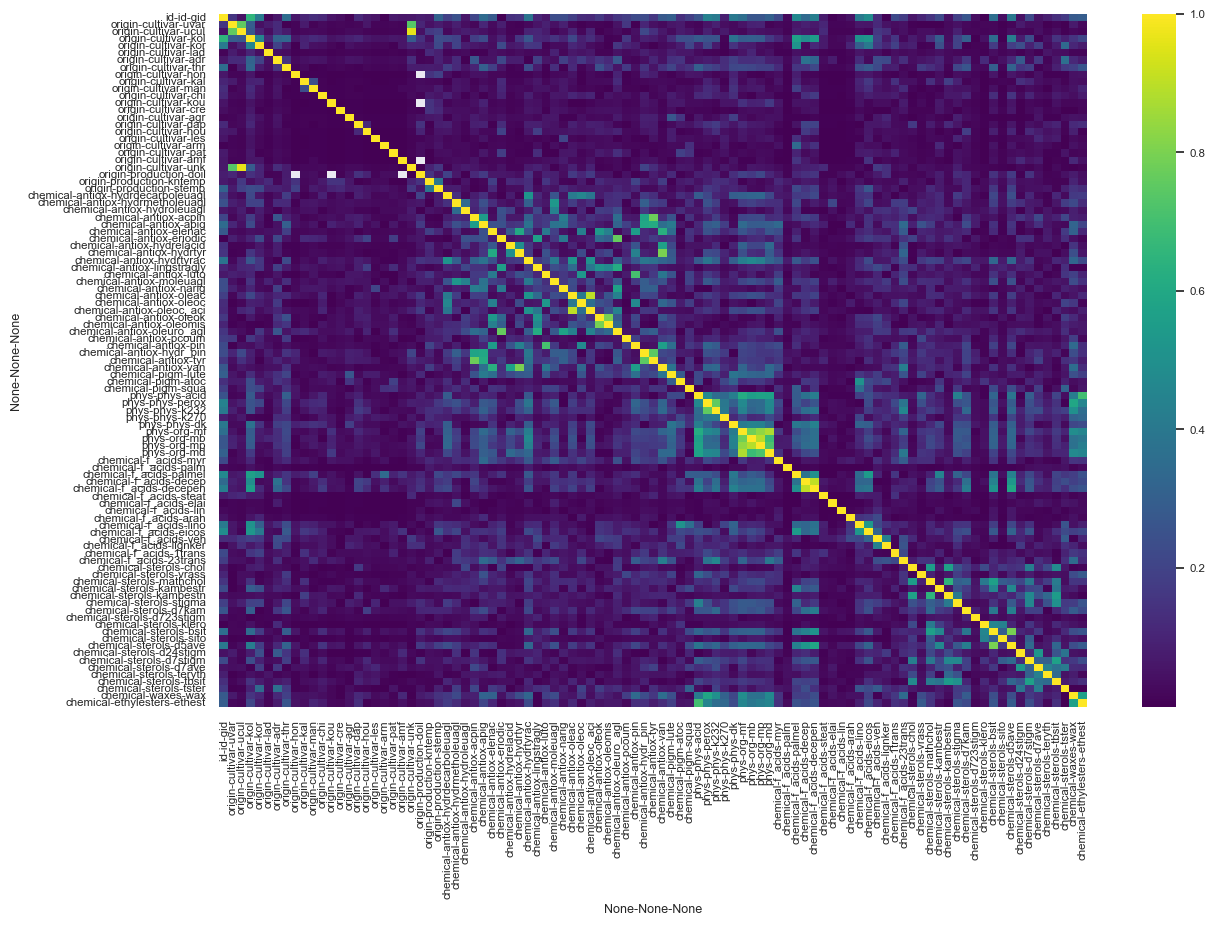

In [17]:
sns.heatmap(cdf.corr().applymap(np.abs), cmap='viridis', xticklabels=True, yticklabels=True)

#### Χημικές Μεταβλητές

<AxesSubplot: xlabel='None-None', ylabel='None-None'>

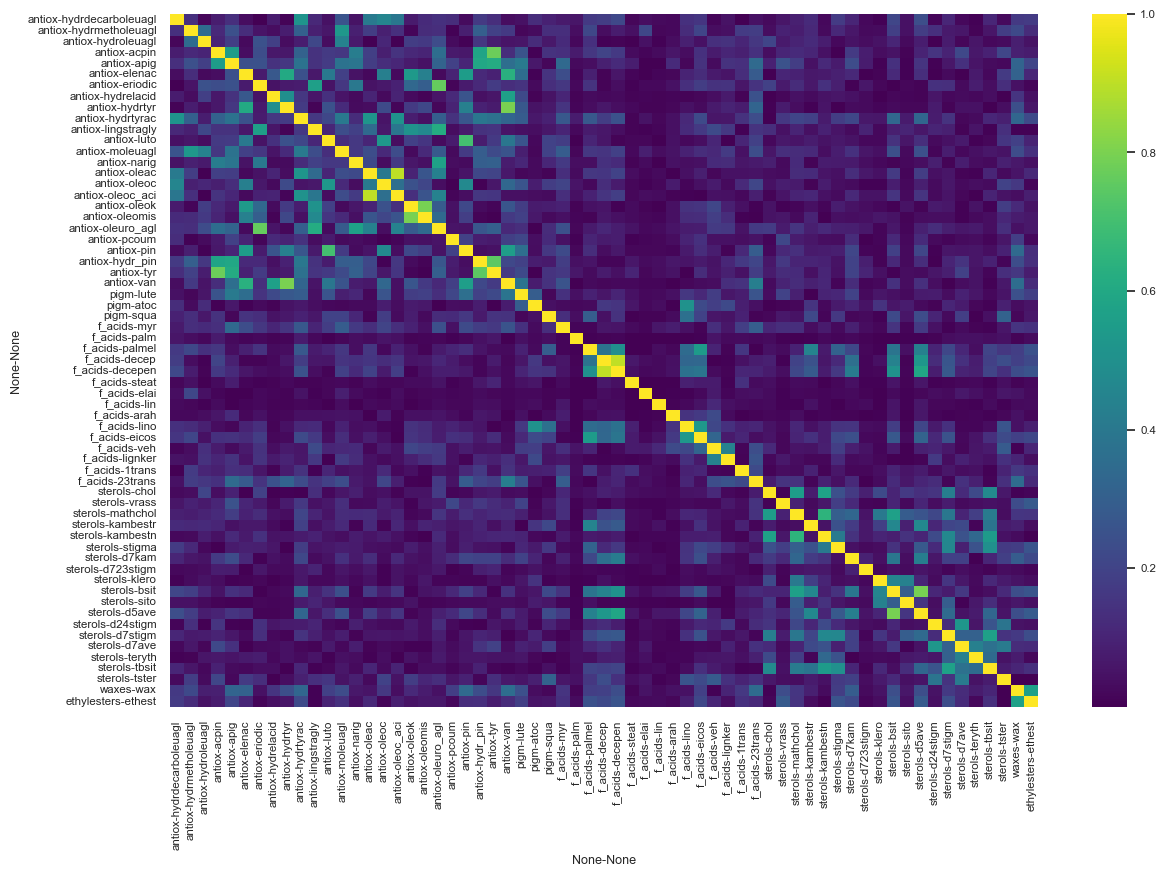

In [18]:
sns.heatmap(cdf.loc[:,'chemical'].corr().applymap(np.abs), cmap='viridis', xticklabels=True, yticklabels=True)

In [19]:
cdf.loc[:,[('origin','location','zn'), ('origin','location','loc') ]+ list(("origin","cultivation", e) for e in cdf.loc[:,('origin', 'cultivation')].columns )]

/tmp/ipykernel_5862/2980327359.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  cdf.loc[:,[('origin','location','zn'), ('origin','location','loc') ]+ list(("origin","cultivation", e) for e in cdf.loc[:,('origin', 'cultivation')].columns )]


origin                                            
    location           cultivation                      
          zn     loc         org_b         altitude  wat
0          6  LESVOS  Conventional      Mountainous   No
1          7  LESVOS  Conventional  Semimountainous  Yes
2          1  LESVOS  Conventional  Semimountainous  Yes
3          1  LESVOS  Conventional  Semimountainous  Yes
4          1  LESVOS  Conventional  Semimountainous   No
..       ...     ...           ...              ...  ...
530        1   CHIOS       Organic  Semimountainous  Yes
531        1   CHIOS       Organic      Mountainous   No
532        1   CHIOS       Organic      Mountainous   No
533        1   CHIOS       Organic      Mountainous   No
534        1   CHIOS       Organic  Semimountainous  Yes

[535 rows x 5 columns]

In [20]:
# Data selection
origin_targets = cdf.loc[:,("origin", ['cultivation','location'])  ].drop(('origin', 'location', 'zn'), axis=1)
m1 = origin_targets.isna().any(axis=1)
chem_indicators =cdf.loc[:,(['chemical'])]
m2 = chem_indicators.isna().any(axis=1)
m = pd.concat([m1, m2],axis=1).any(axis=1)
chem_indicators, origin_targets = chem_indicators.loc[~m,:], origin_targets.loc[~m,:]

In [21]:
t = rowwise_value_counts(origin_targets).astype(int)
t

origin                                                               \
  cultivation                                                     location   
        org_b            altitude                         wat          loc   
 Conventional Organic Mountainous Planar Semimountainous   No Yes    CHIOS   
          283     195         199    157             122  402  76       33   

                              
                              
                              
 FOURNOI IKARIA LESVOS SAMOS  
       5     18    368    54

In [25]:
cs = categorical_scatter(chem_indicators, origin_targets, cols=4, categorical='hue')

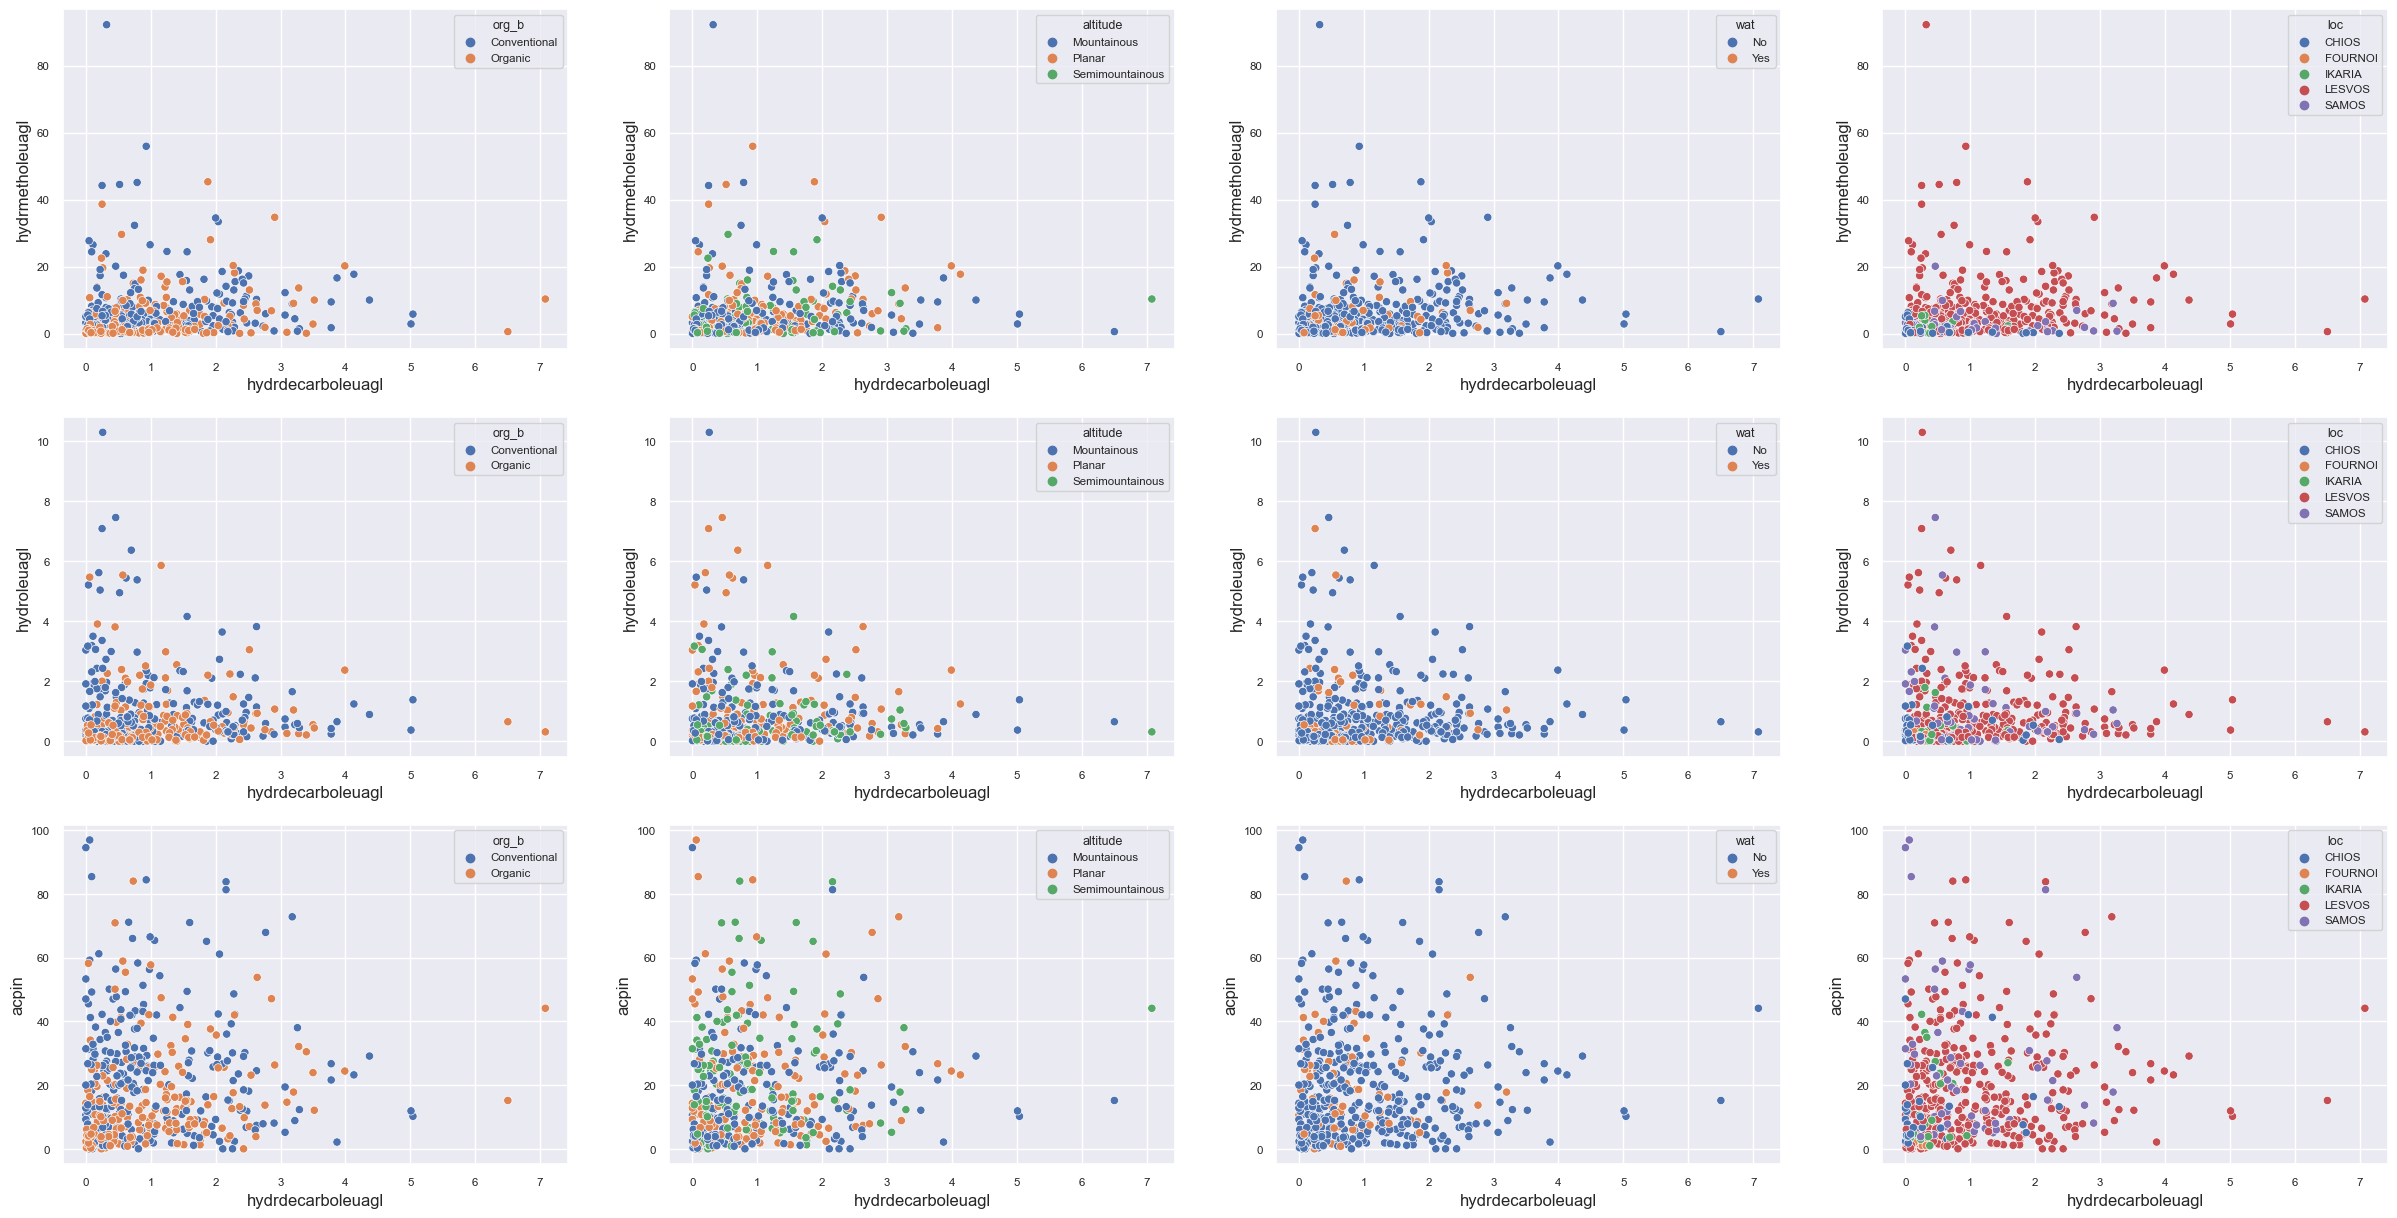

In [26]:
f = next(cs)

[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [63] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [44] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [63] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[44]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


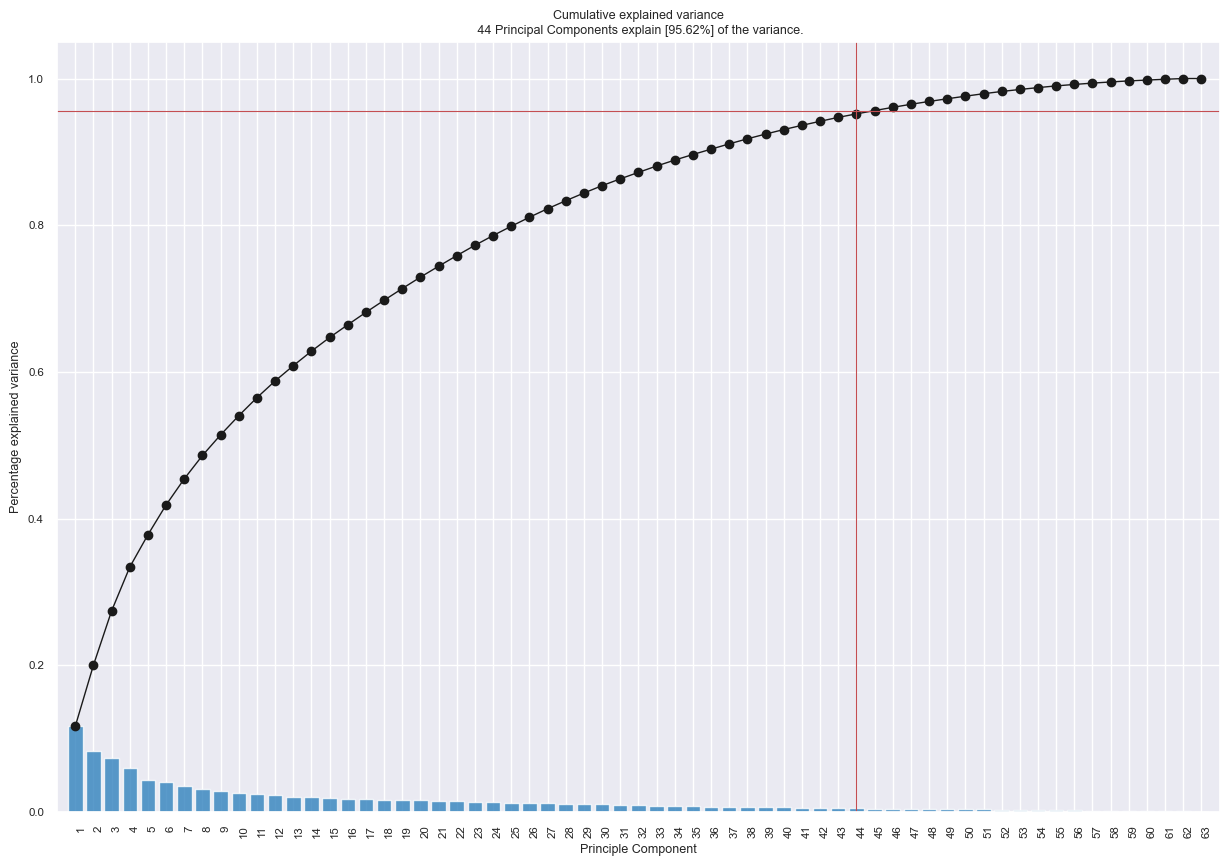

(<Figure size 1500x1000 with 1 Axes>,
 <AxesSubplot: title={'center': 'Cumulative explained variance\n 44 Principal Components explain [95.62%] of the variance.'}, xlabel='Principle Component', ylabel='Percentage explained variance'>)

<Figure size 1400x900 with 0 Axes>

In [27]:
# Load library
from pca import pca

# Initialize pca with default parameters
model = pca(normalize=True)

# Fit transform

results = model.fit_transform(chem_indicators.values, col_labels = tidy_multiindex(chem_indicators).columns.values, row_labels=tidy_multiindex(origin_targets).replace(r_core_mappings).iloc[:,-2].values)

# Plot the explained variance
model.plot()

[pca] >Plot PC1 vs PC2 with loadings.


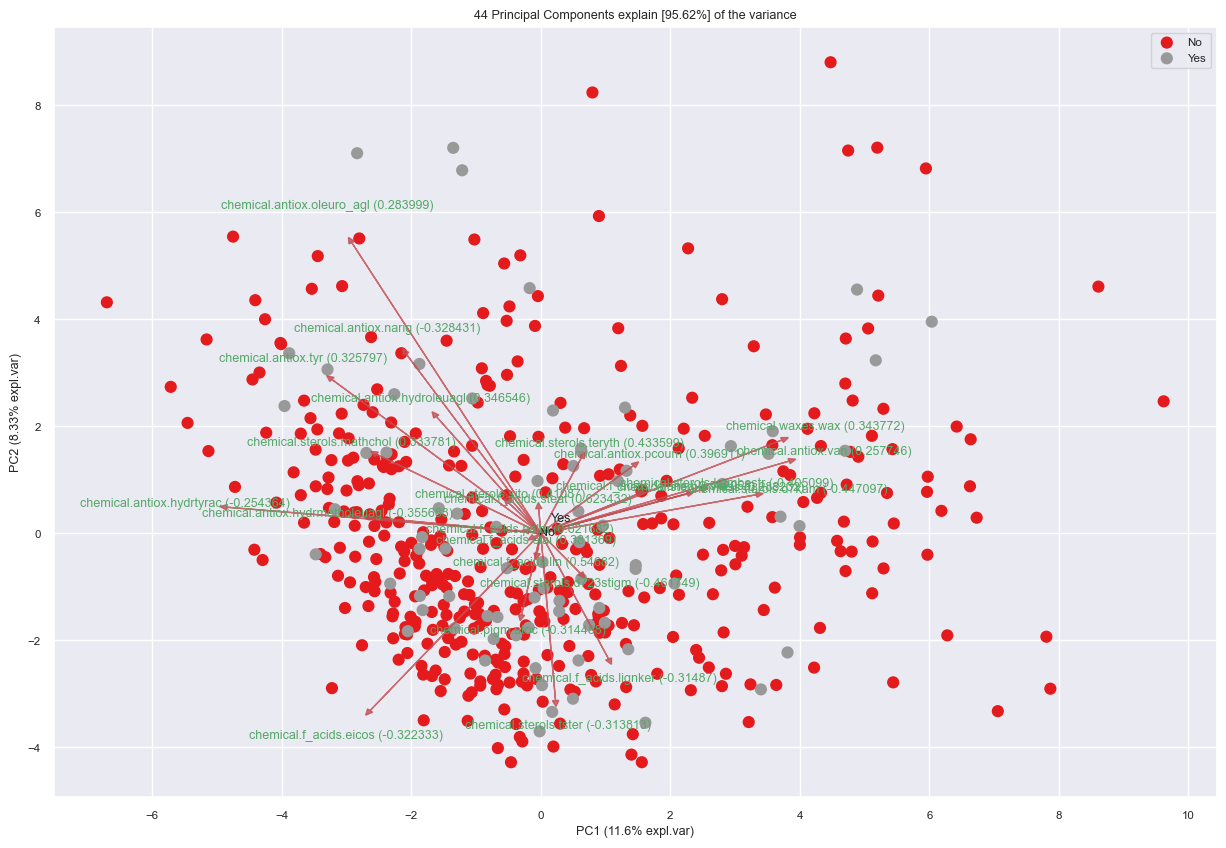

(<Figure size 1500x1000 with 1 Axes>,
 <AxesSubplot: title={'center': '44 Principal Components explain [95.62%] of the variance'}, xlabel='PC1 (11.6% expl.var)', ylabel='PC2 (8.33% expl.var)'>)

In [28]:
model.biplot()

<AxesSubplot: >

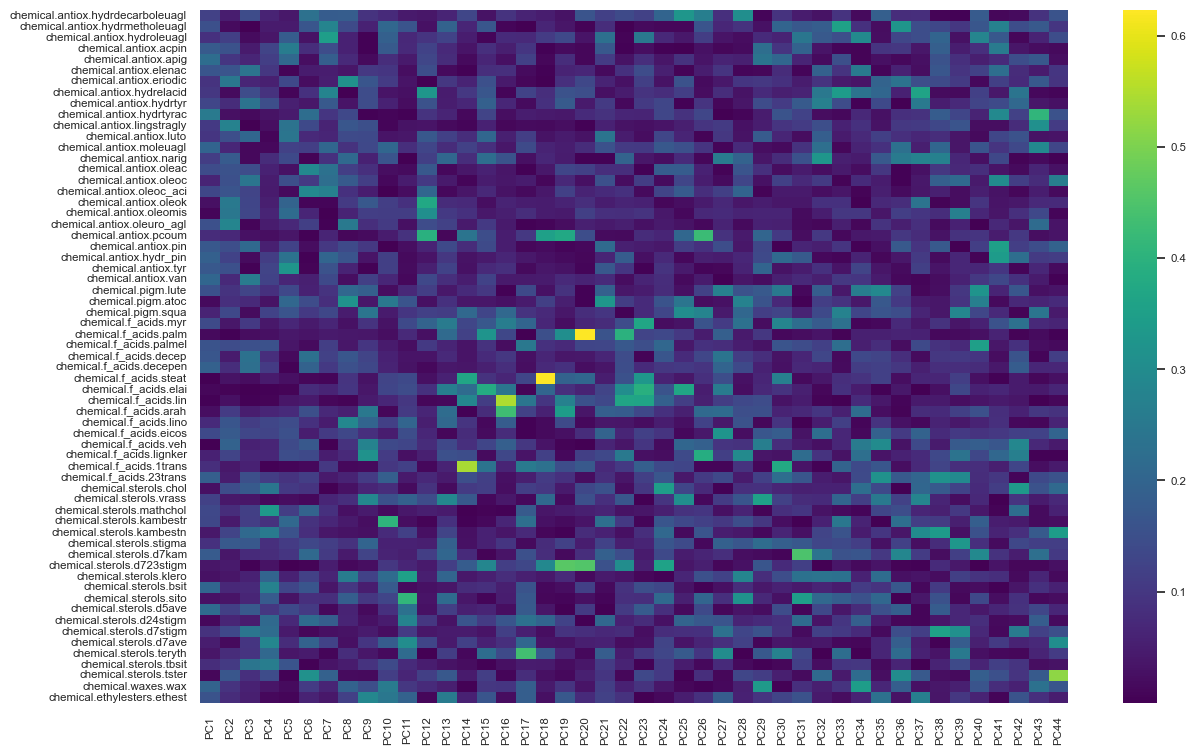

In [29]:
sns.heatmap(model.results['loadings'].applymap(np.abs).T,cmap='viridis', xticklabels=True, yticklabels=True)

## Μοντελοποίηση

### Χαρακτηριστικά Γεωγραφικής Προέλευσης

#### Τοποθεσία

(RandomForestClassifier(criterion='entropy', max_features=None),
 <Figure size 1400x900 with 10 Axes>)

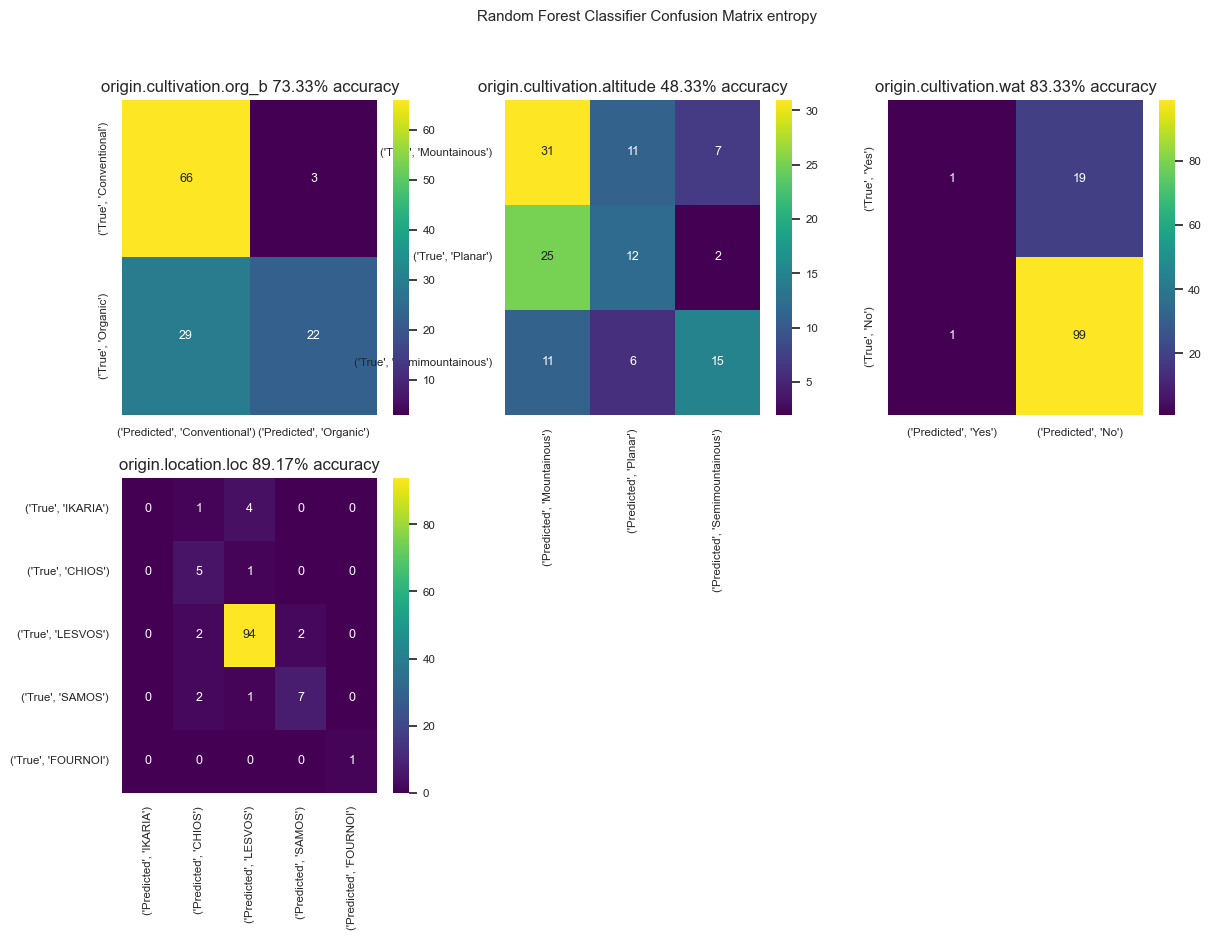

In [103]:
def rand_forest(train_data:tuple=(None, None), test_data:tuple =(None, None),
                criterion:str='entropy', n_estimators:int=100):

    X_train, Y_train = train_data
    X_test, Y_test = test_data
    model = RandomForestClassifier(criterion='entropy', max_features=None, n_estimators=n_estimators)
    c_matrix= {}
    accs = {}
    for col in Y_train.columns:
        model.fit(X_train, Y_train.loc[:,col])
        levels = Y_train.loc[:, col].unique()
        Y_hat = pd.DataFrame(data=model.predict(X_test))
        c_matrix[col] = pd.DataFrame(data=confusion_matrix(Y_test.loc[:,col], Y_hat, labels=Y_train.loc[:,col].unique()),
                                     index = [('True', level) for level in levels], columns = [('Predicted', level) for level in levels] )
        accs[col] = sklearn.metrics.accuracy_score(Y_test.loc[:,col], Y_hat)
    rows=math.ceil(Y_train.shape[1]/3)
    fig, axs = plt.subplots(nrows=rows, ncols=3)
    fig.suptitle(f"Random Forest Classifier Confusion Matrix {criterion}")
    for (i,j), (var, matrix) in itertools.zip_longest(product(range(rows), range(3)), c_matrix.items(), fillvalue=(None, None)):
        if matrix is not None:
            sns.heatmap(c_matrix[var], annot=True, cmap='viridis', ax=axs[i,j])
            axs[i,j].set_title(("{} {:.2f}% accuracy".format(var, accs[var]*100)), fontsize=12)
        else:
            axs[i,j].axis('off')
    return model, fig
Xtr, Xte, Ytr, Yte = train_test_split(chem_indicators, tidy_multiindex(origin_targets), random_state=44)
rand_forest((Xtr, Ytr), (Xte, Yte))

In [ ]:
def preprocessing_data(data:pd.DataFrame,predictors:typing.Optional[typing.Callable]=None,
                           targets:typing.Optional[typing.Callable] = None ,
                           tasks:list[typing.Callable]=[sklearn.preprocessing.MinMaxScaler()]):
    '''
        Utility method to automate data preprocessing prior to model fit
        
        Args:
        ----
        
            - data:pandas.DataFrame := The data to process
            
            - predictors:Callable := A callable filter that takes the dataframe
            and returns predictor variables
            
            - targets:Callable := A callable filter that takes the dataframe as
            input and returns the variables to predict
            
            - tasks:list[Callable] := A list of callables representing the processing
            operations to chain together. Each should take only one argument `df` the
            data to process. Call with `functool.partial` to initialize all other
            arguments
            
        Returns:
        -------
        
            - (ndf,):tuple[pandas.DataFrame, None] := When no target/indicator split
            is provided, returns a tuple, whose first element is the processed
            dataframe
            
            - (indicators, targets):tuple[pandas.DataFrame, pandas.DataFrame] := 
            When a target/indicator split is provided, return a tuple of dataframes
            where the first one is the indicators dataframe and the second is the
            target dataframe
    '''
    

In [54]:
# Data prep
def data_prep(X, Y, dummify:bool=False, scaleX:typing.Union[bool, list[str]]=['']):
    if isinstance(X.columns, pd.MultiIndex):
        _X = tidy_multiindex(X)
    else:
        _X = X
    X = pd.DataFrame(data=sklearn.preprocessing.MinMaxScaler().fit_transform(_X),
                    columns=x.columns, index=x.index)
    if isinstance(Y.columns, pd.MultiIndex):
       _Y =  tidy_multiindex(Y)
    else:
        _Y = Y
    if dummify:
        _Y = pd.get_dummies(_Y)
    Y = tidy_multiindex(_Y.replace(r_core_mappings))
    Xtrain, Xtest, Ytrain, Ytest =sklearn.model_selection.train_test_split(X, Y, random_state = 44)
    return Xtrain, Xtest, Ytrain, Ytest

In [ ]:
x, y = data_prep(chem_indicators, origin_targets)
# m,fig = rand_forest(train_data =(Xtrain, Ytrain), test_data=(Xtest, Ytest))

In [31]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, multilabel_confusion_matrix, confusion_matrix
# from itertools import product
# from sklearn.model_selection import train_test_split


# validation_iters = 10
# # VERY messy. Look into xarray
# t1 = {}
# acc = {}
# s = True
# for i in range(validation_iters):
#     model = RandomForestClassifier(criterion='entropy', max_features=None, n_estimators=100)
#     X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
#     for col in Y.columns:
#         model.fit(X_train, Y_train.loc[:,col])
#         levels = Y_train.loc[:, col].unique()
#         Y_hat = model.predict(X_test)
#         c = confusion_matrix(Y_test.loc[:,col], Y_hat, labels=[v for k, v in mappings[col].items()], normalize='true')
#         t1[col] = c
#     if s:
#         s=not s
#         t2 = t1
#     else:
#         for k, v in t1.items():
#             t2[k] = np.dstack(tuple([v, t1[k]]))
# for k, v in t2.items():
#             levels = Y.loc[:,k].unique()
#             data = np.average(v, axis=2)
#             t2[k] = pd.DataFrame(data = data, index = [('True', level) for level in levels], columns = [('Predicted', level) for level in levels])
            
# fig, axs = plt.subplots(Y.shape[1]%3, 3)
# fig.suptitle("Confusion matrices for Random Forest Classifiers")
# for (i,j), (var, matrix) in zip(product(range(Y.shape[1]%3), range(3)), t2.items()):
#     sns.heatmap(t2[var], annot=True, cmap='viridis', ax=axs[i,j])
#     axs[i,j].set_title(var, fontsize=12)

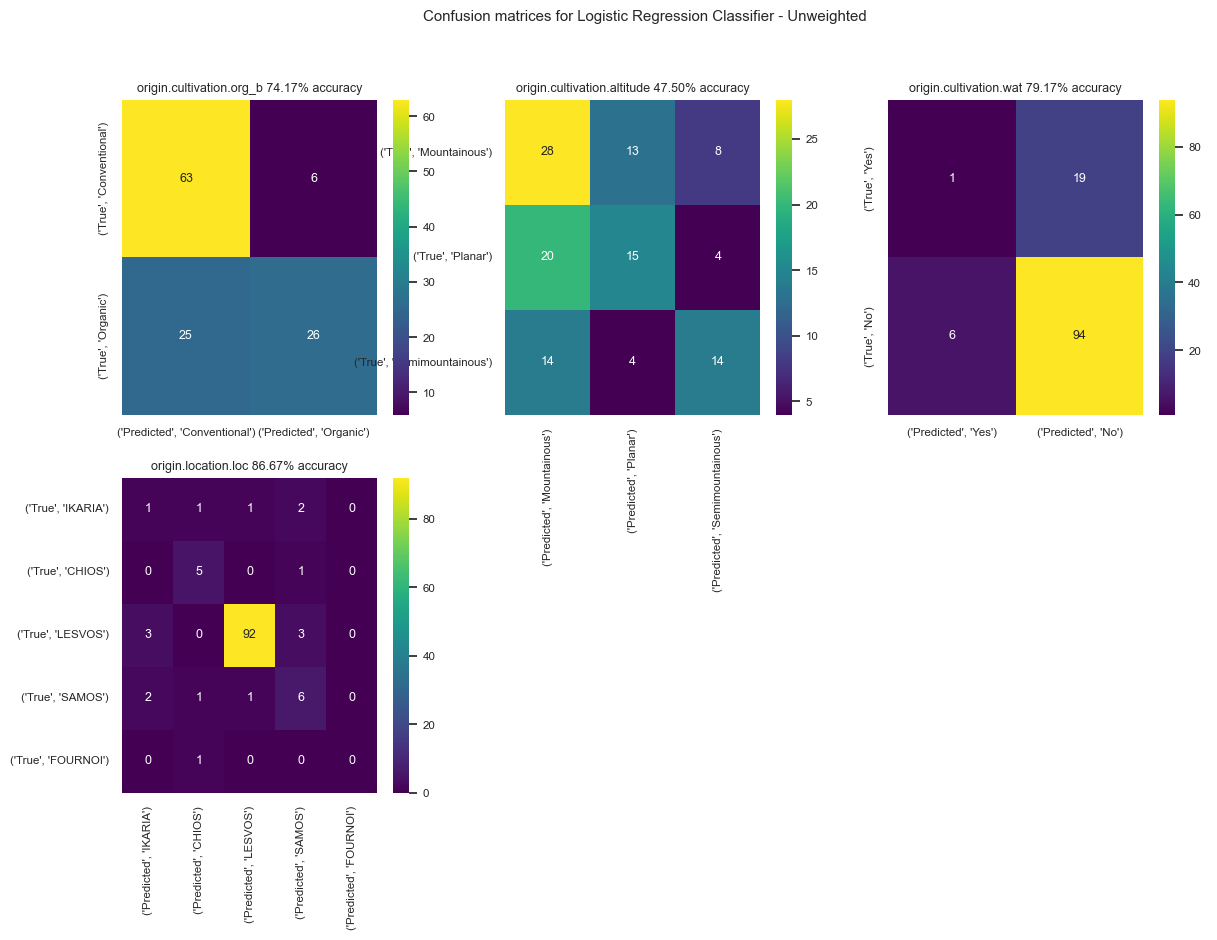

In [123]:
def logit_reg(train_data:tuple=(None, None), test_data:tuple =(None, None),
                class_weight:typing.Optional[str]=None, max_iter:int=10000):
    X_train, Y_train = train_data
    X_test, Y_test = test_data
    targets = Y_train.columns
    models = {}
    for target in targets:
        factors =  Y_train.loc[:,target].unique()
        y_train = Y_train.loc[:,target]
        y_test =  Y_test.loc[:, target]
        logitmodel = sklearn.linear_model.LogisticRegression(max_iter=max_iter, class_weight=class_weight)
        logitmodel.fit(X_train, y_train)
        y_pred = logitmodel.predict(X_test)
        model = dict(
            model = logitmodel,
            error_matrix = pd.DataFrame(data=confusion_matrix(y_test, y_pred, labels =factors),
                                        columns = [('Predicted', e) for e in factors],
                                        index = [('True', e) for e in factors]
            ),
            accuracy = sklearn.metrics.accuracy_score(y_test, y_pred),
            score = logitmodel.score(X_train, y_train),
            decision_function = logitmodel.decision_function(X_train))
        models[target] = model
    rows = math.ceil(Y_train.shape[1]/3)
    fig, axs = plt.subplots(ncols = 3, nrows = rows )
    fig.suptitle("Confusion matrices for Logistic Regression Classifier - {weight}".format(weight='Unweighted ' if class_weight is None else class_weight))
    for (i, j), (target, model) in itertools.zip_longest(product(range(rows),range(3) ), models.items(), fillvalue=(None,None)):
        if model is not None:
            sns.heatmap(model['error_matrix'], annot=True, cmap='viridis', ax = axs[i,j])
            axs[i,j].set_title((target+" {:.2%} accuracy".format(model['accuracy'])))
        else:
            axs[i,j].axis('off')
Xtr, Xte, Ytr, Yte = train_test_split(std_scale(chem_indicators), tidy_multiindex(origin_targets), random_state=44)
logit_reg((Xtr, Ytr), (Xte, Yte))

In [33]:
rowwise_value_counts(origin_targets)

origin                                                               \
  cultivation                                                     location   
        org_b            altitude                         wat          loc   
 Conventional Organic Mountainous Planar Semimountainous   No Yes    CHIOS   
          283     195         199    157             122  402  76       33   

                              
                              
                              
 FOURNOI IKARIA LESVOS SAMOS  
       5     18    368    54

In [34]:
def rebalance():
    from imblearn.over_sampling import ADASYN, SMOTE

    X = chem_indicators
    Y = origin_targets
    X_train, X_test, Y_train, Y_test = train_test_split(chem_indicators, origin_targets, test_size=0.2, random_state=44)
    X_train, X_test = std_scale(X_train), std_scale(X_test)
    targets = Y.columns
    models = {}

    for target in targets:
        factors =  origin_targets.loc[:,target].unique()
        y_train = Y_train.loc[:,target]
        y_test =  Y_test.loc[:, target]
        logitmodel = LogisticRegression(max_iter=10000)
        adasyn = ADASYN(random_state=44, sampling_strategy='minority', n_neighbors=2)
        smote = SMOTE(k_neighbors=2)
        logitmodel.fit(*smote.fit_resample(X_train, y_train))
        y_pred = logitmodel.predict(X_test)
        model = dict(
            model = logitmodel,
            error_matrix = pd.DataFrame(data=confusion_matrix(y_test, y_pred, labels =factors),
                                        columns = [('Predicted', e) for e in factors],
                                        index = [('True', e) for e in factors]
            ),
            accuracy = accuracy_score(y_test, y_pred),
            score = logitmodel.score(X_train, y_train),
            decision_function = logitmodel.decision_function(X_train))
        models[target] = model

    rows = ceil(len(models)/3)

    fig, axs = plt.subplots(ncols = 3, nrows = rows )
    fig.suptitle("Confusion matrices for Logistic Regression Classifier on Location target variables, with ADASYN")
    for (i, j), (target, model) in zip(product(range(3), range(rows) ), models.items()):
        sns.heatmap(model['error_matrix'], annot=True, cmap='viridis', ax = axs[j, i])
        axs[j,i].set_title(target)

##### ANN με GEKKO

In [35]:
r_core_mappings
balancer = {4:22,5:33}

In [36]:
def gekko_ANN(X:pd.DataFrame, Y:pd.DataFrame, layers:list[tuple[str,typing.Optional[int]]]=[('relu', None)],
             exit_nodes:typing.Optional[int]=None, exit_activation:str='linear'):
    from gekko import brain, GEKKO
    model = GEKKO(remote=False)
    model.options.MAX_MEMORY = 7    
    br = brain.Brain(m=model)
    N, M = Y.shape[1], X.shape[1]
    dstring = lambda e: e if e is not None else 'relu'
    istring = lambda e: e if e is not None else M
    processed_layers = [(dstring(e1), istring(e2)) for (e1, e2) in layers]
    ext_sz = exit_nodes if exit_nodes is not None else N
    br.input_layer(M)
    for activation, nodes in processed_layers:
        if activation == 'relu':
            br.layer(relu=nodes)
        elif activation == 'gaussian':
            br.layer(gaussian=nodes)
        elif activation == 'tanh':
            br.layer(sigmoid = nodes)
        elif activation == 'bent':
            br.layer(bent=nodes)
        elif activation == 'leaky':
            br.layer(leaky=nodes)
    br.output_layer(ext_sz, activation=exit_activation)
    try:
        br.learn(X.values.T, Y.values.T)
    except FileNotFoundError:
        raise RuntimeError('Encountered infinities. Network failed to converge')
    return br

In [37]:
X = pd.DataFrame(data = sklearn.decomposition.PCA(n_components = .95).fit_transform(tidy_multiindex(chem_indicators) ))
Y = tidy_multiindex(origin_targets.replace(r_core_mappings))

# def deploy_daemon(func, *args, **kwargs):
#     f = functools.partial(gekko_ANN,X, pd.get_dummies(Y), layers = [('relu', 44) for _ in range(4)] )
#     multiprocessing.Process(target = )

# f = functools.partial(gekko_ANN,X, pd.get_dummies(Y), layers = [('relu', 44) for _ in range(4)] )
# p = multiprocessing.Process(target = f)
# multiprocessing.Process(target= gekko_ANN(X, pd.get_dummies(Y), layers = [('relu', 44) for _ in range(4)])).start()

# ann = gekko_ANN(X, pd.get_dummies(Y), layers = [('relu', 44) for _ in range(4)])

#### ANN με Tensorflow

In [39]:
# from copy import copy
# rlayers = list((math.ceil(e), 'tanh') for e in range(X.shape[1], 2, -10) )
# llayers = copy(rlayers)
# llayers.reverse()
# layers = rlayers+llayers
# layers

In [40]:
# tf_autoencoder(Xtrain, Xtrain, Xtrain, Xtrain, loss='mse', layers=rlayers, epochs=1000)

In [41]:
layers = [(math.ceil(45), 'tanh') for _ in range(1,6)]
layers

[(45, 'tanh'), (45, 'tanh'), (45, 'tanh'), (45, 'tanh'), (45, 'tanh')]

In [42]:
 from imblearn.over_sampling import ADASYN
ada = ADASYN(random_state=44)
Xr, Yr = ADASYN(random_state=44).fit_resample(chem_indicators, origin_targets.replace(r_core_mappings).iloc[:,[0]])

In [43]:
def oversample(X, Y, sampling_strategy:list[float, str]):
    sentinel=True
    Yprime= Y.replace(r_core_mappings)
    for (idx, col), sampling in zip(enumerate(Yprime.columns), sampling_strategy):
        if sampling[1] is None:
            ada = ADASYN(random_state=44, sampling_strategy=sampling[0])
        else:
            ada = ADASYN(random_state=44, sampling_strategy=sampling[0], n_neighbors=sampling[1])
       
        _X, _Y = ada.fit_resample(X, Yprime.iloc[:,[idx]])
        if not sentinel:
            Yr =pd.concat([Yr, _Y], axis=1)
        else:
            Yr = _Y
            Xr = _X
            sentinel=False
    Xr = pd.DataFrame(data = sklearn.decomposition.PCA(n_components = .99).fit_transform(Xr ))
    return Xr, Yr
x,y=oversample(chem_indicators, origin_targets.iloc[:,[-1]], [
    (balancer,4), ('minority',None), (0.8,None), ('minority', 4), (0.7, None)])
Xtrain, Xtest, Ytrain, Ytest = data_prep(x,y, dummify=True)

({4: 22, 5: 33}, 4)


In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
m = tf_model(Xtrain, Xtest, Ytrain, Ytest, factivation = 'sigmoid', 
        loss='categorical_crossentropy', metrics = ['accuracy'],
        epochs=4000, layers=layers , callbacks=[tensorboard_callback],
        verbosity=1)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_18 (Dense)            (None, 45)                270       
                                                                 
 dense_19 (Dense)            (None, 45)                2070      
                                                                 
 dense_20 (Dense)            (None, 45)                2070      
                                                                 
 dense_21 (Dense)            (None, 45)                2070      
                                                                 
 dense_22 (Dense)            (None, 45)                2070      
                                                                 
 dense_23 (Dense)            (None, 1)                 46  

### Ποικηλίες

In [ ]:
cdf[cdf.loc[:,('origin', 'cultivar')].isna().any(axis=1)].loc[:, ('origin', 'cultivar')]

In [ ]:

with pymc.Model() as var_model:
    pass